In [1]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import csv

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout, Conv1D, MaxPool1D, Flatten, UpSampling1D, AveragePooling1D#, Flatten
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.python.keras import utils
from tensorflow.keras.callbacks import TensorBoard

In [4]:
path_to_dataset = '../dataset/N_DATA'

In [5]:
def load_dataset():
    x, y = [], []
    directory = os.fsencode(path_to_dataset)
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        pos = filename.find('_')
        label = filename[pos+1:-4]
        data = []
        with open(path_to_dataset+'/'+filename, newline='') as f:
            reader = csv.reader(f, delimiter=';')
            data = [[float(y) for y in x] for x in list(reader)]
        data = np.array(data).T.tolist()
        data.pop(0)
        data.pop(-1)
        x.append(np.array(data).flatten())
        y.append(int(label))
    return np.array(x), np.array(y)

In [14]:
'''
Стандартная загрузка
'''
x, y = load_dataset()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(411, 2807) (137, 2807) (411,) (137,)


выбранные модели - loss

model_64 0.2221636027097702

model_128 0.22172345221042633

model_512 0.2214939296245575

попробуем также dropout на: (не улучшилось)

model_3_128 0.2220713496208191

Берем model_64 с 2 слоями, тк ошибка почти не отличается от 128, 64 признака намного лучше 512 и они будут самые значимые

In [7]:
input_layer = Input(shape=(2807,))

encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(64, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(2807, activation='sigmoid')(decoded)

model_64 = Model(input_layer, decoded)

К данной задаче может подойти сверточная, объясняем почему, пробуем сверточные сети

In [6]:
'''
Удалим первые нули чтобы форма была (400, 7) для сохранения формы после пуллинга
'''
x, y = load_dataset()
x = np.array([point.reshape(401, 7) for point in x])
x = np.array([point[1:] for point in x])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(411, 400, 7) (137, 400, 7) (411,) (137,)


In [17]:
input_layer = Input(shape=(400, 7))

def conv(kernels, kernel_size, pool, latent_dim=64, activation='relu'):
    
    encoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(input_layer)
    encoded = MaxPool1D(pool, padding='same')(encoded)
    
    encoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(encoded)
    encoded = MaxPool1D(pool, padding='same')(encoded)
    
#     encoded = Flatten()(encoded)
#     encoded = Dense(latent_dim)(encoded)

    decoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(encoded)
    decoded = UpSampling1D(pool)(decoded)
    
    decoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(decoded)
    decoded = UpSampling1D(pool)(decoded)
    
    decoded = Conv1D(7, kernel_size, activation = 'sigmoid', padding = 'same')(decoded)

    autoencoder = Model(input_layer, decoded)
    return autoencoder

In [18]:
losses = []
pool = 2
for kernels in range(6, 27, 1):# обычно равно число каналов * 2
    for kernel_size in [3, 5, 7, 9, 11, 13]:
        autoencoder = conv(kernels, kernel_size, pool)
        autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
        history = autoencoder.fit(x_train, x_train,
                                  epochs=80,
                                  batch_size=16,
                                  shuffle=True,
                                  verbose=0,
                                  validation_data=(x_test, x_test))
        losses.append(history.history['val_loss'][-1])
        print(f'kernels {kernels}, size {kernel_size}, pool {pool}, loss = {losses[-1]}')

kernels 6, size 3, pool 2, loss = 0.22651450335979462
kernels 6, size 5, pool 2, loss = 0.2266157865524292
kernels 6, size 7, pool 2, loss = 0.22720114886760712
kernels 6, size 9, pool 2, loss = 0.22569230198860168
kernels 6, size 11, pool 2, loss = 0.22604598104953766
kernels 6, size 13, pool 2, loss = 0.22579775750637054
kernels 7, size 3, pool 2, loss = 0.22758673131465912
kernels 7, size 5, pool 2, loss = 0.22710882127285004
kernels 7, size 7, pool 2, loss = 0.22626589238643646
kernels 7, size 9, pool 2, loss = 0.22620545327663422
kernels 7, size 11, pool 2, loss = 0.2262733280658722
kernels 7, size 13, pool 2, loss = 0.2257980853319168
kernels 8, size 3, pool 2, loss = 0.22572994232177734
kernels 8, size 5, pool 2, loss = 0.22649119794368744
kernels 8, size 7, pool 2, loss = 0.2256130427122116
kernels 8, size 9, pool 2, loss = 0.22592855989933014
kernels 8, size 11, pool 2, loss = 0.22567123174667358
kernels 8, size 13, pool 2, loss = 0.2259330153465271
kernels 9, size 3, pool 2, 

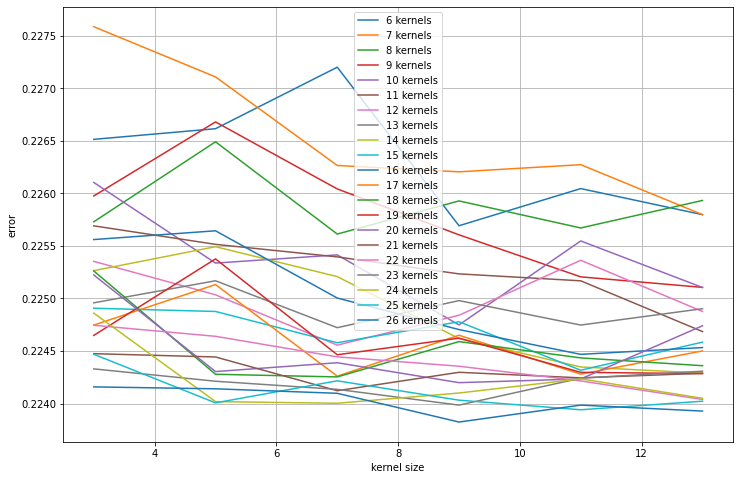

In [19]:
plt.figure(figsize=(14, 8))
plt.grid()
plt.xlabel('kernel size')
plt.ylabel('error')
for i, kernels in enumerate(range(6, 27, 1)):
    plt.plot([3, 5, 7, 9, 11, 13], losses[i*6:i*6+6], label=str(kernels) + ' kernels')
plt.legend()
plt.show()

In [48]:
losses[np.array(losses).argmin()]

0.2263919860124588

22 - 26 ядер дают лучшие рез-ты

видны характерные пики при определенных сочетаниях параметров

попробуем 3 слоя свертки, с еще одним пуллингом, тк иначе слишком много параметров

In [20]:
input_layer = Input(shape=(400, 7))

def conv(kernels, kernel_size, pool, latent_dim=64, activation='relu'):
    
    encoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(input_layer)
    encoded = MaxPool1D(pool, padding='same')(encoded)
    
    encoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(encoded)
    encoded = MaxPool1D(pool, padding='same')(encoded)
    
    encoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(encoded)
    encoded = MaxPool1D(pool, padding='same')(encoded)
    
#     encoded = Flatten()(encoded)
#     encoded = Dense(latent_dim)(encoded)

    decoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(encoded)
    decoded = UpSampling1D(pool)(decoded)
    
    decoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(decoded)
    decoded = UpSampling1D(pool)(decoded)
    
    decoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(decoded)
    decoded = UpSampling1D(pool)(decoded)
    
    decoded = Conv1D(7, kernel_size, activation = 'sigmoid', padding = 'same')(decoded)

    autoencoder = Model(input_layer, decoded)
    return autoencoder

In [21]:
'''
ИСПРАВИТЬ, ВЫБРАТЬ МОДЕЛЬ ПО КОЛ-ВУ ПАРАМЕТРОВ/ОШИБКЕ
(ПЕРЕЗАГРУЗИТЬ И ВЫБОРОЧНО ТЫКАТЬ CELLS)
'''

losses3 = []
pool = 2
for kernels in range(6, 27, 1):# обычно равно число каналов * 2
    for kernel_size in [3, 5, 7, 9, 11]:
        autoencoder = conv(kernels, kernel_size, pool)
        autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
        history = autoencoder.fit(x_train, x_train,
                                  epochs=80,
                                  batch_size=16,
                                  shuffle=True,
                                  verbose=0,
                                  validation_data=(x_test, x_test))
        losses3.append(history.history['val_loss'][-1])
        print(f'kernels {kernels}, size {kernel_size}, pool {pool}, loss = {losses3[-1]}')

kernels 6, size 3, pool 2, loss = 0.2290852665901184
kernels 6, size 5, pool 2, loss = 0.2285221666097641
kernels 6, size 7, pool 2, loss = 0.2282358705997467
kernels 6, size 9, pool 2, loss = 0.22661392390727997
kernels 6, size 11, pool 2, loss = 0.22807574272155762
kernels 7, size 3, pool 2, loss = 0.22962284088134766
kernels 7, size 5, pool 2, loss = 0.22789697349071503
kernels 7, size 7, pool 2, loss = 0.2274937480688095
kernels 7, size 9, pool 2, loss = 0.22773881256580353
kernels 7, size 11, pool 2, loss = 0.22660909593105316
kernels 8, size 3, pool 2, loss = 0.22825782001018524
kernels 8, size 5, pool 2, loss = 0.2278781235218048
kernels 8, size 7, pool 2, loss = 0.22674091160297394
kernels 8, size 9, pool 2, loss = 0.2270035296678543
kernels 8, size 11, pool 2, loss = 0.22682619094848633
kernels 9, size 3, pool 2, loss = 0.22883623838424683
kernels 9, size 5, pool 2, loss = 0.22690381109714508
kernels 9, size 7, pool 2, loss = 0.22620369493961334
kernels 9, size 9, pool 2, loss

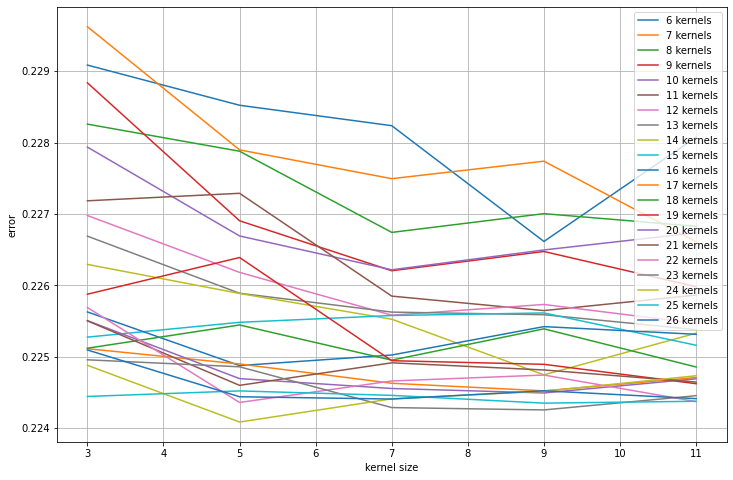

In [22]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.xlabel('kernel size')
plt.ylabel('error')
for i, kernels in enumerate(range(6, 27, 1)):
    plt.plot([3, 5, 7, 9, 11], losses3[i*5:i*5+5], label=str(kernels) + ' kernels')
plt.legend()
plt.show()

на число фич влияет число фильтров, если взять поме

график средней ошибки для 2 и 3 слоев -> обоснование выбора числа слоев

try average pooling для 2 слоев -> анализ

choose model

use keras.reshape

In [10]:
input_layer = Input(shape=(400, 7))

def conv(kernels, kernel_size, pool, latent_dim=64, activation='relu'):
    
    encoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(input_layer)
    encoded = AveragePooling1D(pool, padding='same')(encoded)
    
    encoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(encoded)
    encoded = AveragePooling1D(pool, padding='same')(encoded)
    
#     encoded = Flatten()(encoded)
#     encoded = Dense(latent_dim)(encoded)

    decoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(encoded)
    decoded = UpSampling1D(pool)(decoded)
    
    decoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(decoded)
    decoded = UpSampling1D(pool)(decoded)
    
    decoded = Conv1D(7, kernel_size, activation = 'sigmoid', padding = 'same')(decoded)

    autoencoder = Model(input_layer, decoded)
    return autoencoder

In [11]:
losses3_avg = []
pool = 2
for kernels in range(6, 27, 1):# обычно равно число каналов * 2
    for kernel_size in [3, 5, 7, 9, 11]:
        autoencoder = conv(kernels, kernel_size, pool)
        autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
        history = autoencoder.fit(x_train, x_train,
                                  epochs=80,
                                  batch_size=16,
                                  shuffle=True,
                                  verbose=0,
                                  validation_data=(x_test, x_test))
        losses3_avg.append(history.history['val_loss'][-1])
        print(f'kernels {kernels}, size {kernel_size}, pool {pool}, loss = {losses3_avg[-1]}')

kernels 6, size 3, pool 2, loss = 0.22823625802993774
kernels 6, size 5, pool 2, loss = 0.22960165143013
kernels 6, size 7, pool 2, loss = 0.22769403457641602
kernels 6, size 9, pool 2, loss = 0.22838184237480164
kernels 6, size 11, pool 2, loss = 0.22837130725383759
kernels 7, size 3, pool 2, loss = 0.22784513235092163
kernels 7, size 5, pool 2, loss = 0.22878077626228333
kernels 7, size 7, pool 2, loss = 0.2269703447818756
kernels 7, size 9, pool 2, loss = 0.22900624573230743
kernels 7, size 11, pool 2, loss = 0.2282850295305252
kernels 8, size 3, pool 2, loss = 0.22855998575687408
kernels 8, size 5, pool 2, loss = 0.2275189906358719
kernels 8, size 7, pool 2, loss = 0.22898492217063904
kernels 8, size 9, pool 2, loss = 0.2283509373664856
kernels 8, size 11, pool 2, loss = 0.2282222956418991
kernels 9, size 3, pool 2, loss = 0.2287788838148117
kernels 9, size 5, pool 2, loss = 0.2276144176721573
kernels 9, size 7, pool 2, loss = 0.2278090864419937
kernels 9, size 9, pool 2, loss = 0.

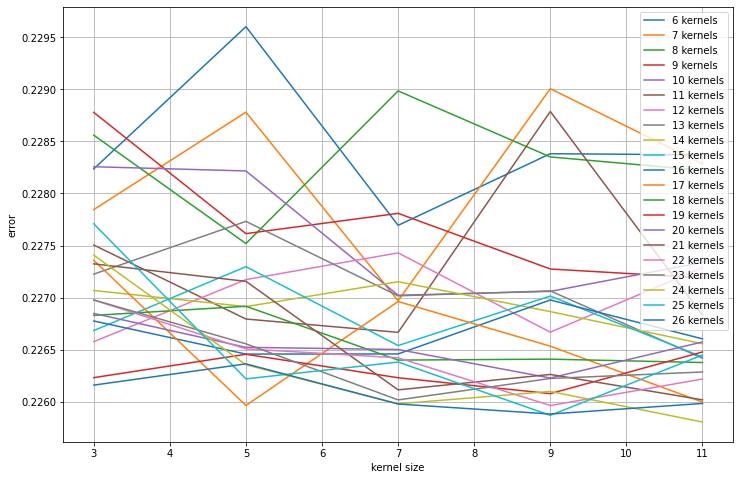

In [14]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.xlabel('kernel size')
plt.ylabel('error')
for i, kernels in enumerate(range(6, 27, 1)):
    plt.plot([3, 5, 7, 9, 11], losses3_avg[i*5:i*5+5], label=str(kernels) + ' kernels')
plt.legend()
plt.show()

In [15]:
input_layer = Input(shape=(400, 7))

def conv(kernels, kernel_size, pool, latent_dim=64, activation='relu'):
    
    encoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(input_layer)
    encoded = AveragePooling1D(pool, padding='same')(encoded)
    
    encoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(encoded)
    encoded = AveragePooling1D(pool, padding='same')(encoded)
    
    encoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(encoded)
    encoded = AveragePooling1D(pool, padding='same')(encoded)
    
#     encoded = Flatten()(encoded)
#     encoded = Dense(latent_dim)(encoded)

    decoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(encoded)
    decoded = UpSampling1D(pool)(decoded)
    
    decoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(decoded)
    decoded = UpSampling1D(pool)(decoded)
    
    decoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(decoded)
    decoded = UpSampling1D(pool)(decoded)
    
    decoded = Conv1D(7, kernel_size, activation = 'sigmoid', padding = 'same')(decoded)

    autoencoder = Model(input_layer, decoded)
    return autoencoder

In [16]:
losses_avg = []
pool = 2
for kernels in range(6, 27, 1):# обычно равно число каналов * 2
    for kernel_size in [3, 5, 7, 9, 11]:
        autoencoder = conv(kernels, kernel_size, pool)
        autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
        history = autoencoder.fit(x_train, x_train,
                                  epochs=80,
                                  batch_size=16,
                                  shuffle=True,
                                  verbose=0,
                                  validation_data=(x_test, x_test))
        losses_avg.append(history.history['val_loss'][-1])
        print(f'kernels {kernels}, size {kernel_size}, pool {pool}, loss = {losses_avg[-1]}')

kernels 6, size 3, pool 2, loss = 0.23013797402381897
kernels 6, size 5, pool 2, loss = 0.2297573685646057
kernels 6, size 7, pool 2, loss = 0.22948110103607178
kernels 6, size 9, pool 2, loss = 0.22961263358592987
kernels 6, size 11, pool 2, loss = 0.22942490875720978
kernels 7, size 3, pool 2, loss = 0.23052802681922913
kernels 7, size 5, pool 2, loss = 0.22950732707977295
kernels 7, size 7, pool 2, loss = 0.22948330640792847
kernels 7, size 9, pool 2, loss = 0.23019865155220032
kernels 7, size 11, pool 2, loss = 0.22903300821781158
kernels 8, size 3, pool 2, loss = 0.23813574016094208
kernels 8, size 5, pool 2, loss = 0.22864240407943726
kernels 8, size 7, pool 2, loss = 0.22956769168376923
kernels 8, size 9, pool 2, loss = 0.22880856692790985
kernels 8, size 11, pool 2, loss = 0.22878722846508026
kernels 9, size 3, pool 2, loss = 0.22989104688167572
kernels 9, size 5, pool 2, loss = 0.22915062308311462
kernels 9, size 7, pool 2, loss = 0.2286849170923233
kernels 9, size 9, pool 2, 

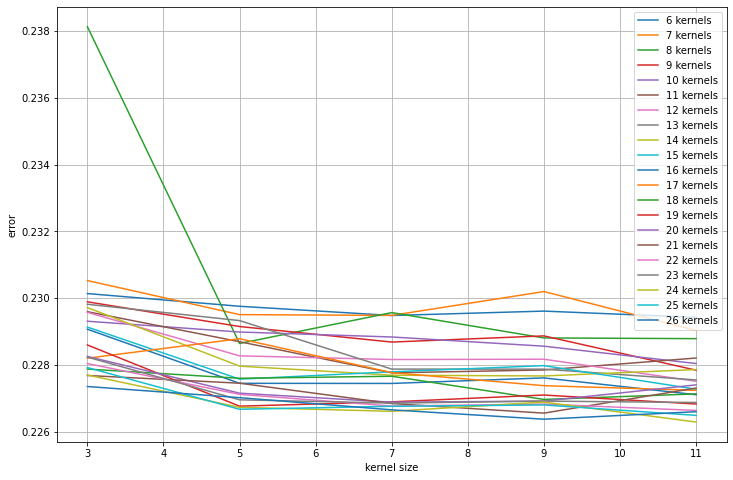

In [17]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.xlabel('kernel size')
plt.ylabel('error')
for i, kernels in enumerate(range(6, 27, 1)):
    plt.plot([3, 5, 7, 9, 11], losses_avg[i*5:i*5+5], label=str(kernels) + ' kernels')
plt.legend()
plt.show()

In [7]:
input_layer = Input(shape=(400, 7))

def conv(kernels, kernel_size, pool, latent_dim=64, activation='relu'):
    
    encoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(input_layer)
    encoded = MaxPool1D(pool, padding='same')(encoded)
    
    encoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(encoded)
    encoded = MaxPool1D(pool, padding='same')(encoded)
    
    encoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(encoded)
    encoded = MaxPool1D(pool, padding='same')(encoded)
    
#     encoded = Flatten()(encoded)
#     encoded = Dense(latent_dim)(encoded)

    decoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(encoded)
    decoded = UpSampling1D(pool)(decoded)
    
    decoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(decoded)
    decoded = UpSampling1D(pool)(decoded)
    
    decoded = Conv1D(kernels, kernel_size, activation = 'relu', padding = 'same')(decoded)
    decoded = UpSampling1D(pool)(decoded)
    
    decoded = Conv1D(7, kernel_size, activation = 'sigmoid', padding = 'same')(decoded)

    autoencoder = Model(input_layer, decoded)
    return autoencoder

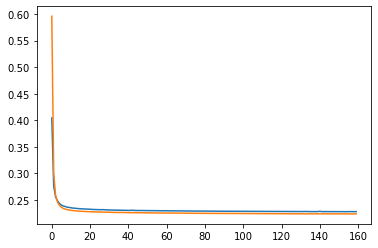

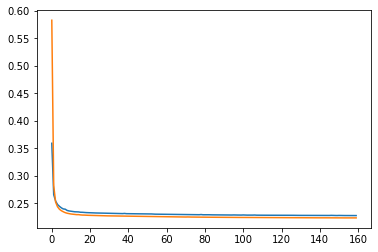

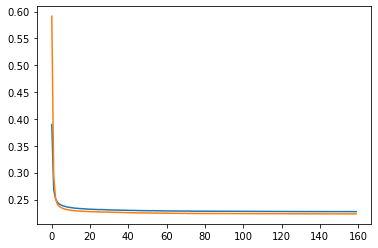

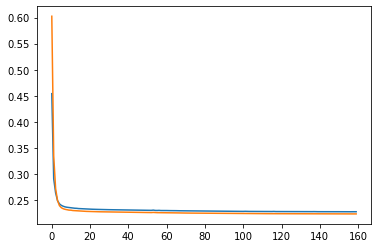

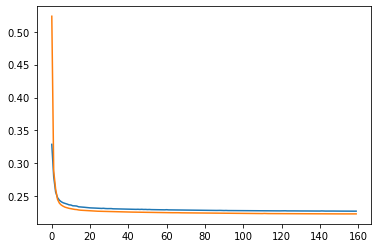

kernels 16, size 5, pool 2, loss = 0.22759650349617006


In [9]:
# обучить 3 слоя на большом кол-ве эпох
# в 2 слоя воткнуть pool = 4 и pool = 2 в двух комбинациях и сравнить
errors = []
pool = 2
kernels = 16
kernel_size = 5
for i in range(5):
    autoencoder = conv(kernels, kernel_size, pool)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    history = autoencoder.fit(x_train, x_train,
                        epochs=160,
                        batch_size=16,
                        shuffle=True,
                        verbose=0,
                        validation_data=(x_test, x_test))
    errors.append(history.history['val_loss'][-1])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.show()

print(f'kernels {kernels}, size {kernel_size}, pool {pool}, loss = {np.sum(errors) / 5}')

In [10]:
input_layer = Input(shape=(400, 7))

def conv(kernels, kernel_size, pool, latent_dim=64, activation='relu'):
    
    encoded = Conv1D(kernels, kernel_size, activation = 'elu', padding = 'same')(input_layer)
    encoded = MaxPool1D(pool, padding='same')(encoded)
    
    encoded = Conv1D(kernels, kernel_size, activation = 'elu', padding = 'same')(encoded)
    encoded = MaxPool1D(pool, padding='same')(encoded)
    
    encoded = Conv1D(kernels, kernel_size, activation = 'elu', padding = 'same')(encoded)
    encoded = MaxPool1D(pool, padding='same')(encoded)
    
#     encoded = Flatten()(encoded)
#     encoded = Dense(latent_dim)(encoded)

    decoded = Conv1D(kernels, kernel_size, activation = 'elu', padding = 'same')(encoded)
    decoded = UpSampling1D(pool)(decoded)
    
    decoded = Conv1D(kernels, kernel_size, activation = 'elu', padding = 'same')(decoded)
    decoded = UpSampling1D(pool)(decoded)
    
    decoded = Conv1D(kernels, kernel_size, activation = 'elu', padding = 'same')(decoded)
    decoded = UpSampling1D(pool)(decoded)
    
    decoded = Conv1D(7, kernel_size, activation = 'sigmoid', padding = 'same')(decoded)

    autoencoder = Model(input_layer, decoded)
    return autoencoder

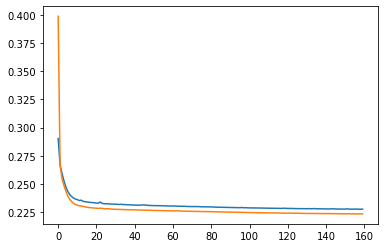

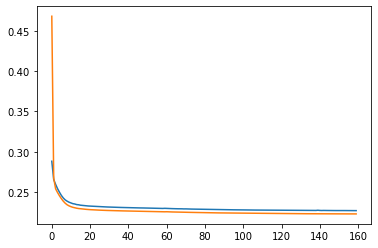

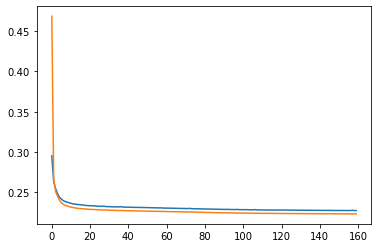

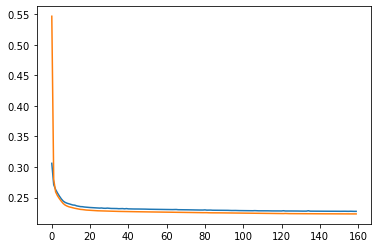

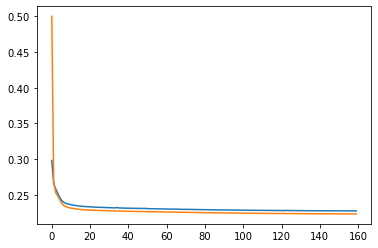

kernels 16, size 5, pool 2, loss = 0.22747887074947357


In [11]:
errors = []
pool = 2
kernels = 16
kernel_size = 5
for i in range(5):
    autoencoder = conv(kernels, kernel_size, pool)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    history = autoencoder.fit(x_train, x_train,
                        epochs=160,
                        batch_size=16,
                        shuffle=True,
                        verbose=0,
                        validation_data=(x_test, x_test))
    errors.append(history.history['val_loss'][-1])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.show()

print(f'kernels {kernels}, size {kernel_size}, pool {pool}, loss = {np.sum(errors) / 5}')

In [ ]:
kernels = 20
kernel_size = 9
pool = 2

conv_model = conv(kernels, kernel_size, pool)
conv_model.summary()
# conv_model.compile(optimizer='adam', loss='binary_crossentropy')
# history = autoencoder.fit(x_train, x_train,
#                           epochs=80,
#                           batch_size=16,
#                           shuffle=True,
#                           verbose=1,
#                           validation_data=(x_test, x_test))

# Исправленные графики

In [66]:
input_str = '''kernels 6, size 3, pool 2, loss = 0.22651450335979462
kernels 6, size 5, pool 2, loss = 0.2266157865524292
kernels 6, size 7, pool 2, loss = 0.22720114886760712
kernels 6, size 9, pool 2, loss = 0.22569230198860168
kernels 6, size 11, pool 2, loss = 0.22604598104953766
kernels 6, size 13, pool 2, loss = 0.22579775750637054
kernels 7, size 3, pool 2, loss = 0.22758673131465912
kernels 7, size 5, pool 2, loss = 0.22710882127285004
kernels 7, size 7, pool 2, loss = 0.22626589238643646
kernels 7, size 9, pool 2, loss = 0.22620545327663422
kernels 7, size 11, pool 2, loss = 0.2262733280658722
kernels 7, size 13, pool 2, loss = 0.2257980853319168
kernels 8, size 3, pool 2, loss = 0.22572994232177734
kernels 8, size 5, pool 2, loss = 0.22649119794368744
kernels 8, size 7, pool 2, loss = 0.2256130427122116
kernels 8, size 9, pool 2, loss = 0.22592855989933014
kernels 8, size 11, pool 2, loss = 0.22567123174667358
kernels 8, size 13, pool 2, loss = 0.2259330153465271
kernels 9, size 3, pool 2, loss = 0.22597567737102509
kernels 9, size 5, pool 2, loss = 0.22668032348155975
kernels 9, size 7, pool 2, loss = 0.22604256868362427
kernels 9, size 9, pool 2, loss = 0.22560575604438782
kernels 9, size 11, pool 2, loss = 0.22520583868026733
kernels 9, size 13, pool 2, loss = 0.22510570287704468
kernels 10, size 3, pool 2, loss = 0.22610417008399963
kernels 10, size 5, pool 2, loss = 0.22533684968948364
kernels 10, size 7, pool 2, loss = 0.2254147231578827
kernels 10, size 9, pool 2, loss = 0.22474855184555054
kernels 10, size 11, pool 2, loss = 0.22554773092269897
kernels 10, size 13, pool 2, loss = 0.22510474920272827
kernels 11, size 3, pool 2, loss = 0.2256913036108017
kernels 11, size 5, pool 2, loss = 0.22551517188549042
kernels 11, size 7, pool 2, loss = 0.2253957837820053
kernels 11, size 9, pool 2, loss = 0.22523418068885803
kernels 11, size 11, pool 2, loss = 0.22516807913780212
kernels 11, size 13, pool 2, loss = 0.22468526661396027
kernels 12, size 3, pool 2, loss = 0.22535334527492523
kernels 12, size 5, pool 2, loss = 0.2250349521636963
kernels 12, size 7, pool 2, loss = 0.2245558798313141
kernels 12, size 9, pool 2, loss = 0.22484037280082703
kernels 12, size 11, pool 2, loss = 0.225363627076149
kernels 12, size 13, pool 2, loss = 0.22487643361091614
kernels 13, size 3, pool 2, loss = 0.22495868802070618
kernels 13, size 5, pool 2, loss = 0.2251686453819275
kernels 13, size 7, pool 2, loss = 0.22472207248210907
kernels 13, size 9, pool 2, loss = 0.2249799370765686
kernels 13, size 11, pool 2, loss = 0.22474715113639832
kernels 13, size 13, pool 2, loss = 0.2249026596546173
kernels 14, size 3, pool 2, loss = 0.2252648025751114
kernels 14, size 5, pool 2, loss = 0.225492924451828
kernels 14, size 7, pool 2, loss = 0.22520826756954193
kernels 14, size 9, pool 2, loss = 0.22461913526058197
kernels 14, size 11, pool 2, loss = 0.22434818744659424
kernels 14, size 13, pool 2, loss = 0.22428980469703674
kernels 15, size 3, pool 2, loss = 0.22490733861923218
kernels 15, size 5, pool 2, loss = 0.2248765230178833
kernels 15, size 7, pool 2, loss = 0.22457870841026306
kernels 15, size 9, pool 2, loss = 0.22477853298187256
kernels 15, size 11, pool 2, loss = 0.22431720793247223
kernels 15, size 13, pool 2, loss = 0.2245846539735794
kernels 16, size 3, pool 2, loss = 0.22556072473526
kernels 16, size 5, pool 2, loss = 0.22564424574375153
kernels 16, size 7, pool 2, loss = 0.22500424087047577
kernels 16, size 9, pool 2, loss = 0.2247041016817093
kernels 16, size 11, pool 2, loss = 0.2244681715965271
kernels 16, size 13, pool 2, loss = 0.22453288733959198
kernels 17, size 3, pool 2, loss = 0.22474652528762817
kernels 17, size 5, pool 2, loss = 0.22513256967067719
kernels 17, size 7, pool 2, loss = 0.2242603749036789
kernels 17, size 9, pool 2, loss = 0.22465002536773682
kernels 17, size 11, pool 2, loss = 0.22427985072135925
kernels 17, size 13, pool 2, loss = 0.22450099885463715
kernels 18, size 3, pool 2, loss = 0.22526219487190247
kernels 18, size 5, pool 2, loss = 0.2242787927389145
kernels 18, size 7, pool 2, loss = 0.2242535501718521
kernels 18, size 9, pool 2, loss = 0.22458966076374054
kernels 18, size 11, pool 2, loss = 0.22443446516990662
kernels 18, size 13, pool 2, loss = 0.2243601381778717
kernels 19, size 3, pool 2, loss = 0.224648579955101
kernels 19, size 5, pool 2, loss = 0.22537682950496674
kernels 19, size 7, pool 2, loss = 0.2244642972946167
kernels 19, size 9, pool 2, loss = 0.2246224582195282
kernels 19, size 11, pool 2, loss = 0.22429706156253815
kernels 19, size 13, pool 2, loss = 0.2242845743894577
kernels 20, size 3, pool 2, loss = 0.22522389888763428
kernels 20, size 5, pool 2, loss = 0.22430451214313507
kernels 20, size 7, pool 2, loss = 0.22438836097717285
kernels 20, size 9, pool 2, loss = 0.22419895231723785
kernels 20, size 11, pool 2, loss = 0.22423449158668518
kernels 20, size 13, pool 2, loss = 0.22474052011966705
kernels 21, size 3, pool 2, loss = 0.22447480261325836
kernels 21, size 5, pool 2, loss = 0.22444333136081696
kernels 21, size 7, pool 2, loss = 0.22412212193012238
kernels 21, size 9, pool 2, loss = 0.22429753839969635
kernels 21, size 11, pool 2, loss = 0.22424456477165222
kernels 21, size 13, pool 2, loss = 0.2242882251739502
kernels 22, size 3, pool 2, loss = 0.22474484145641327
kernels 22, size 5, pool 2, loss = 0.2246399223804474
kernels 22, size 7, pool 2, loss = 0.2244444191455841
kernels 22, size 9, pool 2, loss = 0.22435534000396729
kernels 22, size 11, pool 2, loss = 0.2242152988910675
kernels 22, size 13, pool 2, loss = 0.22403916716575623
kernels 23, size 3, pool 2, loss = 0.22433006763458252
kernels 23, size 5, pool 2, loss = 0.2242123931646347
kernels 23, size 7, pool 2, loss = 0.22413502633571625
kernels 23, size 9, pool 2, loss = 0.22398513555526733
kernels 23, size 11, pool 2, loss = 0.22424164414405823
kernels 23, size 13, pool 2, loss = 0.2243078500032425
kernels 24, size 3, pool 2, loss = 0.2248607575893402
kernels 24, size 5, pool 2, loss = 0.22401835024356842
kernels 24, size 7, pool 2, loss = 0.22400300204753876
kernels 24, size 9, pool 2, loss = 0.2241002917289734
kernels 24, size 11, pool 2, loss = 0.2242351770401001
kernels 24, size 13, pool 2, loss = 0.2240498661994934
kernels 25, size 3, pool 2, loss = 0.22446931898593903
kernels 25, size 5, pool 2, loss = 0.22400660812854767
kernels 25, size 7, pool 2, loss = 0.22421658039093018
kernels 25, size 9, pool 2, loss = 0.22403210401535034
kernels 25, size 11, pool 2, loss = 0.2239408642053604
kernels 25, size 13, pool 2, loss = 0.22402246296405792
kernels 26, size 3, pool 2, loss = 0.2241586595773697
kernels 26, size 5, pool 2, loss = 0.22414037585258484
kernels 26, size 7, pool 2, loss = 0.22409753501415253
kernels 26, size 9, pool 2, loss = 0.2238241285085678
kernels 26, size 11, pool 2, loss = 0.22398529946804047
kernels 26, size 13, pool 2, loss = 0.2239283323287964'''
losses_2_max = []
for line in list(input_str.splitlines()):
    index_eq = line.rfind('=')
#     print(line, index_eq)
    str_loss = line[index_eq+1:]
    losses_2_max.append(float(str_loss))

mean_losses_2 = []
for i in range(21):
    mean_losses_2.append(np.mean(losses_2_max[i:i+5]))

<BarContainer object of 21 artists>

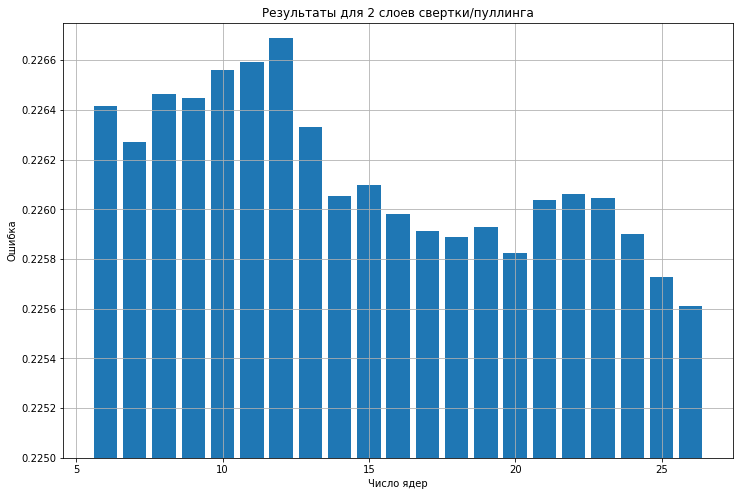

In [67]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.xlabel('Число ядер')
plt.ylabel('Ошибка')
plt.title('Результаты для 2 слоев свертки/пуллинга')
plt.ylim(0.225, 0.22675)
plt.bar([i+6 for i in range(21)], mean_losses_2)

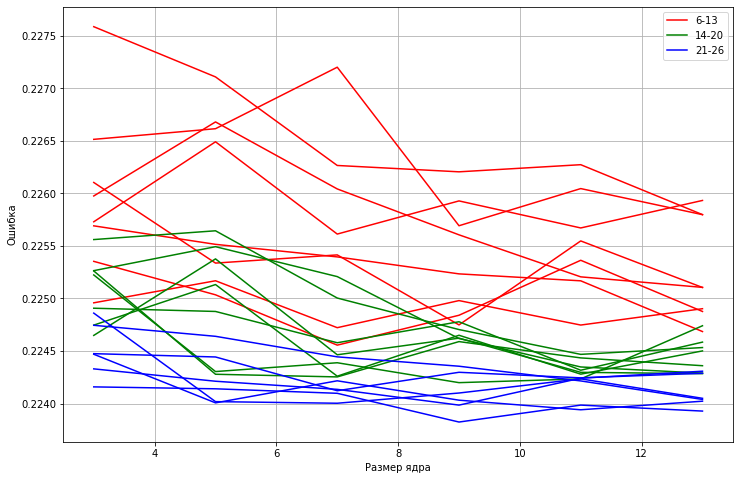

In [60]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.xlabel('Размер ядра')
plt.ylabel('Ошибка')

from matplotlib.lines import Line2D
legend_el = [Line2D([0], [0], color='r', label='6-13'),
             Line2D([0], [0], color='g', label='14-20'),
             Line2D([0], [0], color='b', label='21-26')]

for i, kernels in enumerate(range(6, 27, 1)):
    plt.plot([3, 5, 7, 9, 11, 13],
             losses_2_max[i*6:i*6+6],
             label=str(kernels) + ' kernels',
             color='r' if kernels<=13 else 'g' if kernels<=20 else 'b')
plt.legend(handles=legend_el, loc=0)
plt.show()

In [68]:
input_str = '''kernels 6, size 3, pool 2, loss = 0.2290852665901184
kernels 6, size 5, pool 2, loss = 0.2285221666097641
kernels 6, size 7, pool 2, loss = 0.2282358705997467
kernels 6, size 9, pool 2, loss = 0.22661392390727997
kernels 6, size 11, pool 2, loss = 0.22807574272155762
kernels 7, size 3, pool 2, loss = 0.22962284088134766
kernels 7, size 5, pool 2, loss = 0.22789697349071503
kernels 7, size 7, pool 2, loss = 0.2274937480688095
kernels 7, size 9, pool 2, loss = 0.22773881256580353
kernels 7, size 11, pool 2, loss = 0.22660909593105316
kernels 8, size 3, pool 2, loss = 0.22825782001018524
kernels 8, size 5, pool 2, loss = 0.2278781235218048
kernels 8, size 7, pool 2, loss = 0.22674091160297394
kernels 8, size 9, pool 2, loss = 0.2270035296678543
kernels 8, size 11, pool 2, loss = 0.22682619094848633
kernels 9, size 3, pool 2, loss = 0.22883623838424683
kernels 9, size 5, pool 2, loss = 0.22690381109714508
kernels 9, size 7, pool 2, loss = 0.22620369493961334
kernels 9, size 9, pool 2, loss = 0.2264736145734787
kernels 9, size 11, pool 2, loss = 0.22597961127758026
kernels 10, size 3, pool 2, loss = 0.22793617844581604
kernels 10, size 5, pool 2, loss = 0.22669096291065216
kernels 10, size 7, pool 2, loss = 0.22621707618236542
kernels 10, size 9, pool 2, loss = 0.22649511694908142
kernels 10, size 11, pool 2, loss = 0.2267354130744934
kernels 11, size 3, pool 2, loss = 0.22718362510204315
kernels 11, size 5, pool 2, loss = 0.22728858888149261
kernels 11, size 7, pool 2, loss = 0.22584831714630127
kernels 11, size 9, pool 2, loss = 0.22564558684825897
kernels 11, size 11, pool 2, loss = 0.22586306929588318
kernels 12, size 3, pool 2, loss = 0.22697757184505463
kernels 12, size 5, pool 2, loss = 0.2261808067560196
kernels 12, size 7, pool 2, loss = 0.22558118402957916
kernels 12, size 9, pool 2, loss = 0.22573134303092957
kernels 12, size 11, pool 2, loss = 0.22546707093715668
kernels 13, size 3, pool 2, loss = 0.22668839991092682
kernels 13, size 5, pool 2, loss = 0.22588835656642914
kernels 13, size 7, pool 2, loss = 0.22562436759471893
kernels 13, size 9, pool 2, loss = 0.22558774054050446
kernels 13, size 11, pool 2, loss = 0.2253786027431488
kernels 14, size 3, pool 2, loss = 0.22629280388355255
kernels 14, size 5, pool 2, loss = 0.2258855402469635
kernels 14, size 7, pool 2, loss = 0.22552455961704254
kernels 14, size 9, pool 2, loss = 0.22474542260169983
kernels 14, size 11, pool 2, loss = 0.2253289669752121
kernels 15, size 3, pool 2, loss = 0.22527383267879486
kernels 15, size 5, pool 2, loss = 0.22548125684261322
kernels 15, size 7, pool 2, loss = 0.22557635605335236
kernels 15, size 9, pool 2, loss = 0.2256125658750534
kernels 15, size 11, pool 2, loss = 0.22516006231307983
kernels 16, size 3, pool 2, loss = 0.2256268411874771
kernels 16, size 5, pool 2, loss = 0.22487537562847137
kernels 16, size 7, pool 2, loss = 0.22502315044403076
kernels 16, size 9, pool 2, loss = 0.2254209965467453
kernels 16, size 11, pool 2, loss = 0.22531364858150482
kernels 17, size 3, pool 2, loss = 0.22511157393455505
kernels 17, size 5, pool 2, loss = 0.2248975932598114
kernels 17, size 7, pool 2, loss = 0.22462742030620575
kernels 17, size 9, pool 2, loss = 0.22452110052108765
kernels 17, size 11, pool 2, loss = 0.2247079610824585
kernels 18, size 3, pool 2, loss = 0.2251184582710266
kernels 18, size 5, pool 2, loss = 0.2254439741373062
kernels 18, size 7, pool 2, loss = 0.22495132684707642
kernels 18, size 9, pool 2, loss = 0.22538980841636658
kernels 18, size 11, pool 2, loss = 0.22485554218292236
kernels 19, size 3, pool 2, loss = 0.22587475180625916
kernels 19, size 5, pool 2, loss = 0.22638918459415436
kernels 19, size 7, pool 2, loss = 0.22494365274906158
kernels 19, size 9, pool 2, loss = 0.22489289939403534
kernels 19, size 11, pool 2, loss = 0.2246212363243103
kernels 20, size 3, pool 2, loss = 0.22550499439239502
kernels 20, size 5, pool 2, loss = 0.22469277679920197
kernels 20, size 7, pool 2, loss = 0.22455431520938873
kernels 20, size 9, pool 2, loss = 0.22449150681495667
kernels 20, size 11, pool 2, loss = 0.22469021379947662
kernels 21, size 3, pool 2, loss = 0.22550229728221893
kernels 21, size 5, pool 2, loss = 0.22459815442562103
kernels 21, size 7, pool 2, loss = 0.2249140441417694
kernels 21, size 9, pool 2, loss = 0.22481389343738556
kernels 21, size 11, pool 2, loss = 0.2246442288160324
kernels 22, size 3, pool 2, loss = 0.22568847239017487
kernels 22, size 5, pool 2, loss = 0.2243581861257553
kernels 22, size 7, pool 2, loss = 0.22465960681438446
kernels 22, size 9, pool 2, loss = 0.22474277019500732
kernels 22, size 11, pool 2, loss = 0.22437039017677307
kernels 23, size 3, pool 2, loss = 0.22495611011981964
kernels 23, size 5, pool 2, loss = 0.22485801577568054
kernels 23, size 7, pool 2, loss = 0.22428691387176514
kernels 23, size 9, pool 2, loss = 0.22425393760204315
kernels 23, size 11, pool 2, loss = 0.22445335984230042
kernels 24, size 3, pool 2, loss = 0.2248796671628952
kernels 24, size 5, pool 2, loss = 0.22408431768417358
kernels 24, size 7, pool 2, loss = 0.22440937161445618
kernels 24, size 9, pool 2, loss = 0.22451534867286682
kernels 24, size 11, pool 2, loss = 0.22473254799842834
kernels 25, size 3, pool 2, loss = 0.22444245219230652
kernels 25, size 5, pool 2, loss = 0.2245202660560608
kernels 25, size 7, pool 2, loss = 0.22445781528949738
kernels 25, size 9, pool 2, loss = 0.2243490070104599
kernels 25, size 11, pool 2, loss = 0.22437526285648346
kernels 26, size 3, pool 2, loss = 0.2250939905643463
kernels 26, size 5, pool 2, loss = 0.22443850338459015
kernels 26, size 7, pool 2, loss = 0.22440655529499054
kernels 26, size 9, pool 2, loss = 0.2245219647884369
kernels 26, size 11, pool 2, loss = 0.22441205382347107'''
losses_3_max = []
for line in list(input_str.splitlines()):
    index_eq = line.rfind('=')
#     print(line, index_eq)
    str_loss = line[index_eq+1:]
    losses_3_max.append(float(str_loss))

mean_losses_3 = []
for i in range(21):
    mean_losses_3.append(np.mean(losses_3_max[i:i+4]))

<BarContainer object of 21 artists>

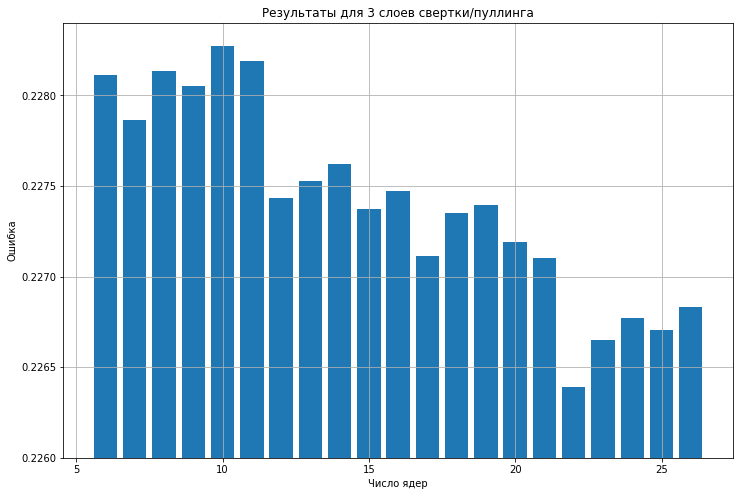

In [69]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.xlabel('Число ядер')
plt.ylabel('Ошибка')
plt.title('Результаты для 3 слоев свертки/пуллинга')
plt.ylim(0.226, 0.2284)
plt.bar([i+6 for i in range(21)], mean_losses_3)

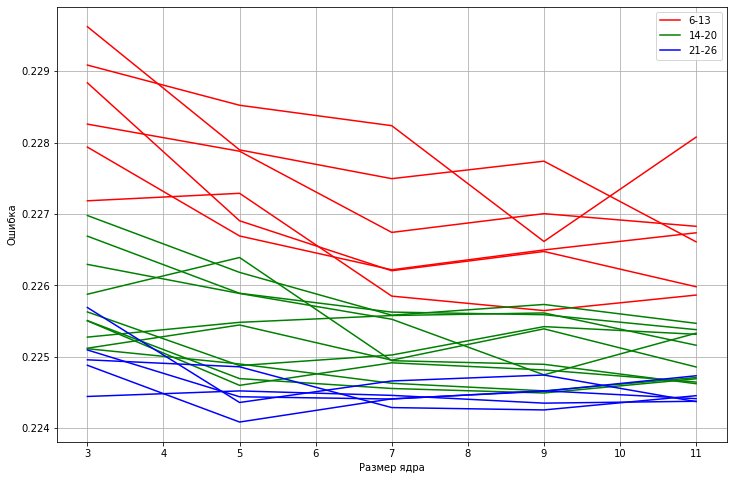

In [63]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.xlabel('Размер ядра')
plt.ylabel('Ошибка')

from matplotlib.lines import Line2D
legend_el = [Line2D([0], [0], color='r', label='6-13'),
             Line2D([0], [0], color='g', label='14-20'),
             Line2D([0], [0], color='b', label='21-26')]

for i, kernels in enumerate(range(6, 27, 1)):
    plt.plot([3, 5, 7, 9, 11],
             losses_3_max[i*5:i*5+5],
             label=str(kernels) + ' kernels',
             color='r' if kernels<=11 else 'g' if kernels<=21 else 'b')
plt.legend(handles=legend_el, loc=0)
plt.show()

In [ ]:
# обучить трехслойную на большом колве эпох

In [73]:
input_str = '''kernels 6, size 3, pool 2, loss = 0.22823625802993774
kernels 6, size 5, pool 2, loss = 0.22960165143013
kernels 6, size 7, pool 2, loss = 0.22769403457641602
kernels 6, size 9, pool 2, loss = 0.22838184237480164
kernels 6, size 11, pool 2, loss = 0.22837130725383759
kernels 7, size 3, pool 2, loss = 0.22784513235092163
kernels 7, size 5, pool 2, loss = 0.22878077626228333
kernels 7, size 7, pool 2, loss = 0.2269703447818756
kernels 7, size 9, pool 2, loss = 0.22900624573230743
kernels 7, size 11, pool 2, loss = 0.2282850295305252
kernels 8, size 3, pool 2, loss = 0.22855998575687408
kernels 8, size 5, pool 2, loss = 0.2275189906358719
kernels 8, size 7, pool 2, loss = 0.22898492217063904
kernels 8, size 9, pool 2, loss = 0.2283509373664856
kernels 8, size 11, pool 2, loss = 0.2282222956418991
kernels 9, size 3, pool 2, loss = 0.2287788838148117
kernels 9, size 5, pool 2, loss = 0.2276144176721573
kernels 9, size 7, pool 2, loss = 0.2278090864419937
kernels 9, size 9, pool 2, loss = 0.2272748202085495
kernels 9, size 11, pool 2, loss = 0.22718986868858337
kernels 10, size 3, pool 2, loss = 0.22825691103935242
kernels 10, size 5, pool 2, loss = 0.22821640968322754
kernels 10, size 7, pool 2, loss = 0.22702285647392273
kernels 10, size 9, pool 2, loss = 0.22705969214439392
kernels 10, size 11, pool 2, loss = 0.22733835875988007
kernels 11, size 3, pool 2, loss = 0.22750486433506012
kernels 11, size 5, pool 2, loss = 0.22679446637630463
kernels 11, size 7, pool 2, loss = 0.2266663908958435
kernels 11, size 9, pool 2, loss = 0.22878745198249817
kernels 11, size 11, pool 2, loss = 0.22683145105838776
kernels 12, size 3, pool 2, loss = 0.22657695412635803
kernels 12, size 5, pool 2, loss = 0.22717298567295074
kernels 12, size 7, pool 2, loss = 0.22742959856987
kernels 12, size 9, pool 2, loss = 0.22666803002357483
kernels 12, size 11, pool 2, loss = 0.22728686034679413
kernels 13, size 3, pool 2, loss = 0.2272254377603531
kernels 13, size 5, pool 2, loss = 0.2277321070432663
kernels 13, size 7, pool 2, loss = 0.22701701521873474
kernels 13, size 9, pool 2, loss = 0.22706446051597595
kernels 13, size 11, pool 2, loss = 0.22641733288764954
kernels 14, size 3, pool 2, loss = 0.22706854343414307
kernels 14, size 5, pool 2, loss = 0.2269134521484375
kernels 14, size 7, pool 2, loss = 0.22715294361114502
kernels 14, size 9, pool 2, loss = 0.2268657237291336
kernels 14, size 11, pool 2, loss = 0.22655721008777618
kernels 15, size 3, pool 2, loss = 0.2266835868358612
kernels 15, size 5, pool 2, loss = 0.22729714214801788
kernels 15, size 7, pool 2, loss = 0.22653964161872864
kernels 15, size 9, pool 2, loss = 0.22701507806777954
kernels 15, size 11, pool 2, loss = 0.22642968595027924
kernels 16, size 3, pool 2, loss = 0.22677555680274963
kernels 16, size 5, pool 2, loss = 0.2264576554298401
kernels 16, size 7, pool 2, loss = 0.2264590561389923
kernels 16, size 9, pool 2, loss = 0.22697722911834717
kernels 16, size 11, pool 2, loss = 0.2266039401292801
kernels 17, size 3, pool 2, loss = 0.2273583710193634
kernels 17, size 5, pool 2, loss = 0.22596445679664612
kernels 17, size 7, pool 2, loss = 0.2269623875617981
kernels 17, size 9, pool 2, loss = 0.2265336513519287
kernels 17, size 11, pool 2, loss = 0.2259969264268875
kernels 18, size 3, pool 2, loss = 0.22682930529117584
kernels 18, size 5, pool 2, loss = 0.2269168496131897
kernels 18, size 7, pool 2, loss = 0.22640003263950348
kernels 18, size 9, pool 2, loss = 0.22640909254550934
kernels 18, size 11, pool 2, loss = 0.22637666761875153
kernels 19, size 3, pool 2, loss = 0.22623153030872345
kernels 19, size 5, pool 2, loss = 0.22645583748817444
kernels 19, size 7, pool 2, loss = 0.2262304276227951
kernels 19, size 9, pool 2, loss = 0.22607794404029846
kernels 19, size 11, pool 2, loss = 0.22647811472415924
kernels 20, size 3, pool 2, loss = 0.22684818506240845
kernels 20, size 5, pool 2, loss = 0.22652257978916168
kernels 20, size 7, pool 2, loss = 0.22650176286697388
kernels 20, size 9, pool 2, loss = 0.22622793912887573
kernels 20, size 11, pool 2, loss = 0.22657406330108643
kernels 21, size 3, pool 2, loss = 0.22732406854629517
kernels 21, size 5, pool 2, loss = 0.22715625166893005
kernels 21, size 7, pool 2, loss = 0.22611425817012787
kernels 21, size 9, pool 2, loss = 0.22626230120658875
kernels 21, size 11, pool 2, loss = 0.22601830959320068
kernels 22, size 3, pool 2, loss = 0.22697699069976807
kernels 22, size 5, pool 2, loss = 0.22650708258152008
kernels 22, size 7, pool 2, loss = 0.2264219969511032
kernels 22, size 9, pool 2, loss = 0.22596375644207
kernels 22, size 11, pool 2, loss = 0.226218119263649
kernels 23, size 3, pool 2, loss = 0.2269776463508606
kernels 23, size 5, pool 2, loss = 0.22655624151229858
kernels 23, size 7, pool 2, loss = 0.22601762413978577
kernels 23, size 9, pool 2, loss = 0.22622321546077728
kernels 23, size 11, pool 2, loss = 0.22628580033779144
kernels 24, size 3, pool 2, loss = 0.22740775346755981
kernels 24, size 5, pool 2, loss = 0.22635500133037567
kernels 24, size 7, pool 2, loss = 0.2259799689054489
kernels 24, size 9, pool 2, loss = 0.2260989546775818
kernels 24, size 11, pool 2, loss = 0.22580517828464508
kernels 25, size 3, pool 2, loss = 0.22770889103412628
kernels 25, size 5, pool 2, loss = 0.22621965408325195
kernels 25, size 7, pool 2, loss = 0.2263810634613037
kernels 25, size 9, pool 2, loss = 0.22586952149868011
kernels 25, size 11, pool 2, loss = 0.22644899785518646
kernels 26, size 3, pool 2, loss = 0.22615958750247955
kernels 26, size 5, pool 2, loss = 0.22636379301548004
kernels 26, size 7, pool 2, loss = 0.22597824037075043
kernels 26, size 9, pool 2, loss = 0.22588223218917847
kernels 26, size 11, pool 2, loss = 0.22598353028297424'''
losses = []
for line in list(input_str.splitlines()):
    index_eq = line.rfind('=')
#     print(line, index_eq)
    str_loss = line[index_eq+1:]
    losses.append(float(str_loss))

mean_losses = []
for i in range(21):
    mean_losses.append(np.mean(losses[i:i+4]))

<BarContainer object of 21 artists>

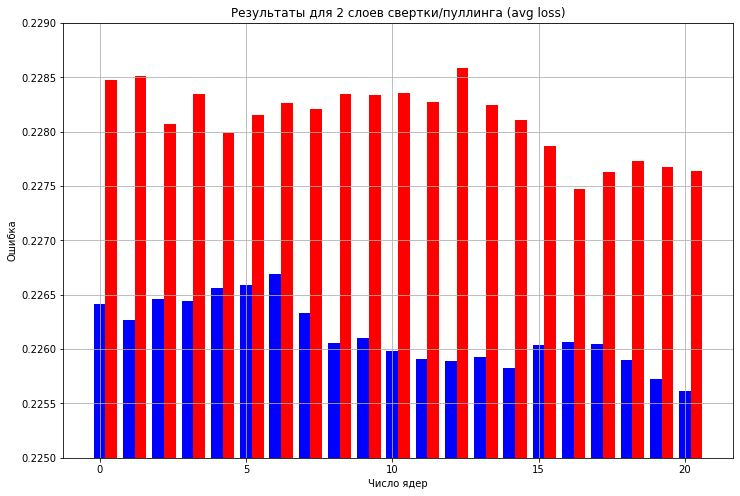

In [87]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.xlabel('Число ядер')
plt.ylabel('Ошибка')
plt.title('Результаты для 2 слоев свертки/пуллинга (avg loss)')
plt.ylim(0.225, 0.229)
bar_x = np.arange(len(mean_losses))
plt.bar(bar_x, mean_losses_2, width=0.4, color='b')
plt.bar(bar_x+0.4, mean_losses, width=0.4, color='r')

In [88]:
input_str = '''kernels 6, size 3, pool 2, loss = 0.23013797402381897
kernels 6, size 5, pool 2, loss = 0.2297573685646057
kernels 6, size 7, pool 2, loss = 0.22948110103607178
kernels 6, size 9, pool 2, loss = 0.22961263358592987
kernels 6, size 11, pool 2, loss = 0.22942490875720978
kernels 7, size 3, pool 2, loss = 0.23052802681922913
kernels 7, size 5, pool 2, loss = 0.22950732707977295
kernels 7, size 7, pool 2, loss = 0.22948330640792847
kernels 7, size 9, pool 2, loss = 0.23019865155220032
kernels 7, size 11, pool 2, loss = 0.22903300821781158
kernels 8, size 3, pool 2, loss = 0.23813574016094208
kernels 8, size 5, pool 2, loss = 0.22864240407943726
kernels 8, size 7, pool 2, loss = 0.22956769168376923
kernels 8, size 9, pool 2, loss = 0.22880856692790985
kernels 8, size 11, pool 2, loss = 0.22878722846508026
kernels 9, size 3, pool 2, loss = 0.22989104688167572
kernels 9, size 5, pool 2, loss = 0.22915062308311462
kernels 9, size 7, pool 2, loss = 0.2286849170923233
kernels 9, size 9, pool 2, loss = 0.22886964678764343
kernels 9, size 11, pool 2, loss = 0.22784237563610077
kernels 10, size 3, pool 2, loss = 0.22930908203125
kernels 10, size 5, pool 2, loss = 0.22898562252521515
kernels 10, size 7, pool 2, loss = 0.2288368046283722
kernels 10, size 9, pool 2, loss = 0.22856146097183228
kernels 10, size 11, pool 2, loss = 0.22804108262062073
kernels 11, size 3, pool 2, loss = 0.22959542274475098
kernels 11, size 5, pool 2, loss = 0.22869528830051422
kernels 11, size 7, pool 2, loss = 0.22776247560977936
kernels 11, size 9, pool 2, loss = 0.22784870862960815
kernels 11, size 11, pool 2, loss = 0.2282065749168396
kernels 12, size 3, pool 2, loss = 0.22957520186901093
kernels 12, size 5, pool 2, loss = 0.2282719910144806
kernels 12, size 7, pool 2, loss = 0.2281617820262909
kernels 12, size 9, pool 2, loss = 0.22817084193229675
kernels 12, size 11, pool 2, loss = 0.227509543299675
kernels 13, size 3, pool 2, loss = 0.22981758415699005
kernels 13, size 5, pool 2, loss = 0.2293282151222229
kernels 13, size 7, pool 2, loss = 0.22787490487098694
kernels 13, size 9, pool 2, loss = 0.22787338495254517
kernels 13, size 11, pool 2, loss = 0.2275497317314148
kernels 14, size 3, pool 2, loss = 0.22971820831298828
kernels 14, size 5, pool 2, loss = 0.2279643714427948
kernels 14, size 7, pool 2, loss = 0.22769178450107574
kernels 14, size 9, pool 2, loss = 0.22766892611980438
kernels 14, size 11, pool 2, loss = 0.22786101698875427
kernels 15, size 3, pool 2, loss = 0.22913430631160736
kernels 15, size 5, pool 2, loss = 0.2275739312171936
kernels 15, size 7, pool 2, loss = 0.2277929037809372
kernels 15, size 9, pool 2, loss = 0.22797833383083344
kernels 15, size 11, pool 2, loss = 0.22727198898792267
kernels 16, size 3, pool 2, loss = 0.2290700376033783
kernels 16, size 5, pool 2, loss = 0.2274484932422638
kernels 16, size 7, pool 2, loss = 0.22744512557983398
kernels 16, size 9, pool 2, loss = 0.2276104986667633
kernels 16, size 11, pool 2, loss = 0.22710742056369781
kernels 17, size 3, pool 2, loss = 0.2282010316848755
kernels 17, size 5, pool 2, loss = 0.22878490388393402
kernels 17, size 7, pool 2, loss = 0.22776895761489868
kernels 17, size 9, pool 2, loss = 0.22737789154052734
kernels 17, size 11, pool 2, loss = 0.22723783552646637
kernels 18, size 3, pool 2, loss = 0.22787538170814514
kernels 18, size 5, pool 2, loss = 0.227599635720253
kernels 18, size 7, pool 2, loss = 0.2276601493358612
kernels 18, size 9, pool 2, loss = 0.22696562111377716
kernels 18, size 11, pool 2, loss = 0.2271323949098587
kernels 19, size 3, pool 2, loss = 0.2285970151424408
kernels 19, size 5, pool 2, loss = 0.2267642319202423
kernels 19, size 7, pool 2, loss = 0.2268935889005661
kernels 19, size 9, pool 2, loss = 0.22709789872169495
kernels 19, size 11, pool 2, loss = 0.226827934384346
kernels 20, size 3, pool 2, loss = 0.22825415432453156
kernels 20, size 5, pool 2, loss = 0.22715309262275696
kernels 20, size 7, pool 2, loss = 0.2268829643726349
kernels 20, size 9, pool 2, loss = 0.22691605985164642
kernels 20, size 11, pool 2, loss = 0.22740206122398376
kernels 21, size 3, pool 2, loss = 0.22768324613571167
kernels 21, size 5, pool 2, loss = 0.22745166718959808
kernels 21, size 7, pool 2, loss = 0.22684310376644135
kernels 21, size 9, pool 2, loss = 0.22655516862869263
kernels 21, size 11, pool 2, loss = 0.2273065745830536
kernels 22, size 3, pool 2, loss = 0.22804084420204163
kernels 22, size 5, pool 2, loss = 0.2271176278591156
kernels 22, size 7, pool 2, loss = 0.22676822543144226
kernels 22, size 9, pool 2, loss = 0.2268250584602356
kernels 22, size 11, pool 2, loss = 0.2266366183757782
kernels 23, size 3, pool 2, loss = 0.22823381423950195
kernels 23, size 5, pool 2, loss = 0.22695402801036835
kernels 23, size 7, pool 2, loss = 0.22685562074184418
kernels 23, size 9, pool 2, loss = 0.2269153743982315
kernels 23, size 11, pool 2, loss = 0.226874440908432
kernels 24, size 3, pool 2, loss = 0.22769750654697418
kernels 24, size 5, pool 2, loss = 0.22672899067401886
kernels 24, size 7, pool 2, loss = 0.22660987079143524
kernels 24, size 9, pool 2, loss = 0.22688625752925873
kernels 24, size 11, pool 2, loss = 0.22628837823867798
kernels 25, size 3, pool 2, loss = 0.22792057693004608
kernels 25, size 5, pool 2, loss = 0.226670503616333
kernels 25, size 7, pool 2, loss = 0.2267596274614334
kernels 25, size 9, pool 2, loss = 0.22680041193962097
kernels 25, size 11, pool 2, loss = 0.226487398147583
kernels 26, size 3, pool 2, loss = 0.22735314071178436
kernels 26, size 5, pool 2, loss = 0.22701875865459442
kernels 26, size 7, pool 2, loss = 0.22665385901927948
kernels 26, size 9, pool 2, loss = 0.22637300193309784
kernels 26, size 11, pool 2, loss = 0.22659806907176971'''
losses = []
for line in list(input_str.splitlines()):
    index_eq = line.rfind('=')
#     print(line, index_eq)
    str_loss = line[index_eq+1:]
    losses.append(float(str_loss))

mean_losses = []
for i in range(21):
    mean_losses.append(np.mean(losses[i:i+4]))

<BarContainer object of 21 artists>

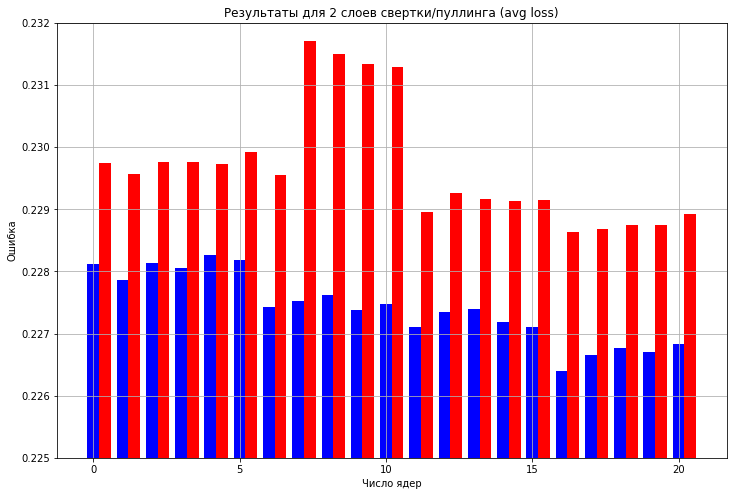

In [92]:
plt.figure(figsize=(12, 8))
plt.grid()
plt.xlabel('Число ядер')
plt.ylabel('Ошибка')
plt.title('Результаты для 3 слоев свертки/пуллинга (avg loss)')
plt.ylim(0.225, 0.232)
bar_x = np.arange(len(mean_losses))
plt.bar(bar_x, mean_losses_3, width=0.4, color='b')
plt.bar(bar_x+0.4, mean_losses, width=0.4, color='r')